## Refining EMP metadata (QIIME mapping files) using Pandas

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime
import math
from collections import defaultdict

In [2]:
pd.set_option("display.max_rows", 200)

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
# path to list of studies (ct112=all) and path to mapping files directory
path_studies = '/Users/luke/emp/metadata-refine/refine_emp_studies_ct112.txt'
path_mapping = '/Users/luke/emp/metadata-qiime-mapping'
path_taxonomy = '/Users/luke/emp/ontology-ncbi-taxonomy/taxdump/names.dmp'
path_empo = '/Users/luke/emp/metadata-refine/empo_samples_unique.xlsx'
path_quality = '/Users/luke/emp/metadata-refine/emp_studies_quality.xlsx'
path_observations = '/Users/luke/emp/otu-picking/emp_observations_97studies.tsv'
path_subsample = '/Users/luke/emp/metadata-refine/modMapping.txt'

### Functions

#### Function for merging mapping files and tallying column headers

In [5]:
def merge_and_tally_mapping_files(path_studies, path_mapping):
    studies = [line.rstrip('\n') for line in open(path_studies)]
    header_counts = defaultdict(int)
    df_merged = pd.DataFrame()
    for study in studies:
        path = '%s/%s_qiime_mapping.tsv' % (path_mapping, study)
        df_single = pd.read_csv(path, sep='\t', header=0, index_col=0, dtype=str)
        for header in df_single.columns:
            header_counts[header] += 1
        df_merged = df_merged.append(df_single, ignore_index=False, verify_integrity=True)
    return df_merged, header_counts

#### Data munging functions

#### Remove trailing ".0" from numeric value in column of df (convert string-float to string-int)

In [6]:
def remove_decimal_zero(df, column):
    return [re.sub(r'\.0', '', x) if x is not np.nan else '' for x in df[column]]

#### Round to hundredths with df.apply(round_hundredths)

In [7]:
def round_hundredths(x):
    x = float(x)
    if math.isnan(x):
        return x
    else:
        return "%.2f" % x

### Read input files and make dictionaries

#### Study quality

In [8]:
df_quality = pd.read_excel(path_quality, index_col=None, dtypes=object)

In [9]:
# dictionary of study_id => title
dict_title = dict(zip(df_quality.study_id.astype(str), df_quality.title))
# dictionary of study_id => ebi_accession
dict_ebi_accession = dict(zip(df_quality.study_id.astype(str), df_quality.ebi_accession))
# dictionary of study_id => emp_paper
dict_emp_paper = dict(zip(df_quality.study_id.astype(str), df_quality.emp_paper))
# dictionary of study_id => dense_sampling
dict_dense_sampling = dict(zip(df_quality.study_id.astype(str), df_quality.dense_sampling))
# dictionary of study_id => metadata_minimal
dict_metadata_minimal = dict(zip(df_quality.study_id.astype(str), df_quality.metadata_minimal))
# dictionary of study_id => units_status
dict_units_status = dict(zip(df_quality.study_id.astype(str), df_quality.units_status))
# dictionary of study_id => study_ok
dict_study_ok = dict(zip(df_quality.study_id.astype(str), df_quality.study_ok))

#### Sequences per sample

In [10]:
df_observations = pd.read_csv(path_observations, sep='\t', index_col=None)

In [11]:
# dictionary of #SampleID => split_libraries
dict_seqs_per_sample = dict(zip(df_observations['#SampleID'], df_observations.split_libraries))

#### Subsampled studies

In [12]:
df_subsample = pd.read_csv(path_subsample, sep='\t', index_col=None)

In [13]:
df_subsample
dict_allemp = dict(zip(df_subsample['#SampleID'], df_subsample.all_emp))
dict_qcfiltered = dict(zip(df_subsample['#SampleID'], df_subsample.qc_filtered))
dict_subset2000 = dict(zip(df_subsample['#SampleID'], df_subsample.subset_2000))
dict_subset5000 = dict(zip(df_subsample['#SampleID'], df_subsample.subset_5000))
dict_subset10000 = dict(zip(df_subsample['#SampleID'], df_subsample.subset_10000))
dict_subset20000 = dict(zip(df_subsample['#SampleID'], df_subsample.subset_20000))

#### NCBI taxonomy

In [14]:
df_tax = pd.read_csv(path_taxonomy, sep='\t\|\t|\t\|', engine='python', header=None)
del df_tax[4]
df_tax.columns = ['tax_id', 'name_txt', 'unique_name', 'name_class']
df_tax['tax_id'] = df_tax['tax_id'].astype(str)

In [15]:
# dictionary of tax_id => genbank common name
df_tax_gcn = df_tax[df_tax['name_class'] == 'genbank common name']
dict_gcn = dict(zip(df_tax_gcn.tax_id, df_tax_gcn.name_txt))

In [16]:
# dictionary of tax_id => scientific name
df_tax_sn = df_tax[df_tax['name_class'] == 'scientific name']
dict_sn = dict(zip(df_tax_sn.tax_id, df_tax_sn.name_txt))

### Read and refine mapping file

#### Read mapping files, tally column headers, and merge into single dataframe

In [17]:
# main code to merge mapping files and count how often column headers appear (~5 min)
df_merged, header_counts = merge_and_tally_mapping_files(path_studies, path_mapping)

In [18]:
# change spaces in indexes to periods (for study 905)
df_merged.index = [re.sub(' ', '.', x) for x in df_merged.index]

In [19]:
# add study_id
df_merged['study_id'] = [re.split(r'\.', x)[0] for x in df_merged.index]

#### Add EMPO columns to merged all columns and select columns (and covert indexes to lowercase to match biom)

In [20]:
df_empo = pd.read_excel(path_empo, index_col=0, dtypes=object)
df_empo.study_id = df_empo.study_id.astype(str)

In [21]:
sampletype_cols = [
    'study_id',
    'env_biome',
    'env_feature',
    'env_matter',
    'sample_type']

In [22]:
df_union_empo = pd.merge(df_merged, df_empo, how='left', left_on=sampletype_cols, right_on=sampletype_cols)
df_union_empo.index = [x for x in df_merged.index]

In [23]:
df_union_empo.to_csv('/Users/luke/emp/metadata-refine/emp_qiime_mapping_union_empo.tsv', sep='\t', index_label='#SampleID')

## Refined mapping file

_Sample_

* SampleID -- no changes needed
* BarcodeSequence -- no changes needed
* LinkerPrimerSequence -- no changes needed
* Description -- no changes needed
* host_subject_id -- no changes needed

_Study & quality_

* study_id -- parsed from SampleID
* title -- using most updated titles (from emp_studies_quality.xlsx)
* ebi_accession -- EBI accession number if submitted (from emp_studies_quality.xlsx)
* emp_paper -- included among 97 studies in 2016 EMP paper (TRUE/FALSE, from emp_studies_quality.xlsx)
* study_ok -- study does not have major issues (from emp_studies_quality.xlsx)
* dense_sampling -- whether the study has highly similar samples (from emp_studies_quality.xlsx)
* metadata_minimal -- whether the study has only minimal metadata (from emp_studies_quality.xlsx)
* units_status -- whether units are provided for measurements (from emp_studies_quality.xlsx)

_Subsample_

* sequences_per_sample -- number of sequences per sample after split libraries (from emp_observations_97studies.tsv)
* all_emp -- samples with >=1 sequences per sample
* qc_filtered -- samples with >1000 sequences per sample but not controls (all subsets are in this set)
* subset_2000 -- 2000 samples evenly distributed across empo_3 categories and then across studies
* subset_5000 -- 5000 samples evenly distributed across empo_3 categories and then across studies
* subset_10000 -- 10000 samples evenly distributed across empo_3 categories and then across studies
* subset_20000 -- 20000 samples evenly distributed across empo_3 categories and then across studies

_Taxonomy_

* taxon_id -- removed trailing ".0", fixed Excel Auto Fill and other typos
* scientific_name -- deleted values that refer to host or don't match lookup value
* scientific_name_lookup -- looked up from names.dmp using taxon_id
* host_taxid -- removed trailing ".0", fixed Excel Auto Fill typos
* host_common_name -- no changes made, but see lookup value
* host_common_name_lookup -- looked up from names.dmp using host_taxid
* host_scientific_name_lookup -- looked up from names.dmp using host_taxid

_Geography_

* collection_timestamp -- removed timestamps after today's date
* country -- fixed misspellings
* latitude -- fixed errors
* longitude -- fixed errors
* depth -- no changes made
* altitude -- no changes made
* elevation -- no changes made

_Ontology_

* env_biome -- fixed errors
* env_feature -- no changes made -- need additional changes from gDoc
* env_material -- fixed errors, changed name from "env_matter" -- need additional changes from gDoc
* empo_0 -- no changes, inherited from emp_qiime_mapping_sampletype_unique_empo.xlsx
* empo_1 -- no changes, inherited from emp_qiime_mapping_sampletype_unique_empo.xlsx
* empo_2 -- no changes, inherited from emp_qiime_mapping_sampletype_unique_empo.xlsx
* empo_3 -- no changes, inherited from emp_qiime_mapping_sampletype_unique_empo.xlsx

_Environment_

* temperature -- using "temp", "temp_environment", made fully numeric
* ph -- using "ph" (fixed), "ph_cacl2", "sediment_ph", made fully numeric
* salinity -- using "salinity", "samp_salinity", "sediment_salinity", made fully numeric
* oxygen -- no changes made
* nitrogen spp.
* phosphorus spp.
* carbon spp.


### Create dataframe for refined columns

#### Sample metadata

In [24]:
df_refined = pd.DataFrame(index=df_merged.index)
df_refined.index.name = '#SampleID'

In [25]:
df_refined = df_refined.join(df_merged[['BarcodeSequence', 'LinkerPrimerSequence', 'Description', 'host_subject_id']])

#### Study metadata

In [26]:
# adding columns: study_id, title, ebi_accession, emp_paper
df_refined['study_id'] = [re.split(r'\.', x)[0] for x in df_merged.index]
df_refined['title'] = [dict_title[x] if x in dict_title else '' for x in df_refined['study_id']]
df_refined['ebi_accession'] = [dict_ebi_accession[x] if x in dict_ebi_accession else '' for x in df_refined['study_id']]
df_refined['emp_paper'] = [dict_emp_paper[x] if x in dict_emp_paper else '' for x in df_refined['study_id']]
df_refined['study_ok'] = [dict_study_ok[x] if x in dict_study_ok else '' for x in df_refined['study_id']]

#### Quality metadata

In [27]:
# adding columns: dense_sampling, metadata_minimal, units_status, sequences_per_sample, study_ok
df_refined['dense_sampling'] = [dict_dense_sampling[x] if x in dict_dense_sampling else '' for x in df_refined['study_id']]
df_refined['metadata_minimal'] = [dict_metadata_minimal[x] if x in dict_metadata_minimal else '' for x in df_refined['study_id']]
df_refined['units_status'] = [dict_units_status[x] if x in dict_units_status else '' for x in df_refined['study_id']]
df_refined['study_ok'] = [dict_study_ok[x] if x in dict_study_ok else '' for x in df_refined['study_id']]

#### Subsample metadata

In [28]:
df_refined['sequences_per_sample'] = [dict_seqs_per_sample[x] if x in dict_seqs_per_sample else '' for x in df_refined.index]

In [29]:
df_refined['all_emp'] = [dict_allemp[x] if x in dict_allemp else '' for x in df_refined.index]
df_refined['qc_filtered'] = [dict_qcfiltered[x] if x in dict_qcfiltered else '' for x in df_refined.index]
df_refined['subset_2000'] = [dict_subset2000[x] if x in dict_subset2000 else '' for x in df_refined.index]
df_refined['subset_5000'] = [dict_subset5000[x] if x in dict_subset5000 else '' for x in df_refined.index]
df_refined['subset_10000'] = [dict_subset10000[x] if x in dict_subset10000 else '' for x in df_refined.index]
df_refined['subset_20000'] = [dict_subset20000[x] if x in dict_subset20000 else '' for x in df_refined.index]

#### Taxonomy metadata

##### Sample taxonomy

In [30]:
df_refined = df_refined.join(df_merged[['taxon_id', 'scientific_name']])

In [31]:
# taxon_id -- remove trailing ".0"
df_refined['taxon_id'] = remove_decimal_zero(df_refined, 'taxon_id')
# taxon_id -- fix Excel Auto Fill typos
# Study ??
df_refined['taxon_id'][df_merged['taxon_id'] == '718309'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718310'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718311'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718312'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718313'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718314'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718315'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718316'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718317'] = '718308'
# Study 10145 -- beach sand metagenome should be 412757
df_refined['taxon_id'][(df_merged['taxon_id'] == '412758') & (df_refined['study_id'] == '10145')] = '412757'
df_refined['taxon_id'][(df_merged['taxon_id'] == '412760') & (df_refined['study_id'] == '10145')] = '412757'
df_refined['taxon_id'][(df_merged['taxon_id'] == '412762') & (df_refined['study_id'] == '10145')] = '412757'
# Study 10278 -- peat metagenome should be 1799672
df_refined['taxon_id'][df_refined['study_id'] == '10278'] = '1799672'

In [32]:
# scientific_name_lookup -- look up from names.dmp using taxon_id 
df_refined['scientific_name_lookup'] = [dict_sn[x] if x in dict_sn else '' for x in df_refined['taxon_id']]

In [33]:
# scientific_name -- delete values that refer to host and not sample
df_refined['scientific_name'][df_refined['study_id'] == '1734'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '1795'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '1889'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10146'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10245'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10273'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10323'] = np.nan

# scientific_name -- delete values that are close but not quite right
df_refined['scientific_name'][df_refined['study_id'] == '10145'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10156'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10180'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10278'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10308'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10346'] = np.nan

In [34]:
# Check that lookup and given values match
# If scientific_name given, does it match lookup value?
df_sample_sn = df_refined[[x is not np.nan for x in df_refined['scientific_name']]][['scientific_name', 'scientific_name_lookup']]
df_sample_sn[df_sample_sn['scientific_name'] != df_sample_sn['scientific_name_lookup']]

,scientific_name,scientific_name_lookup
#SampleID,,


##### Host taxonomy

In [35]:
df_refined = df_refined.join(df_merged[['host_taxid', 'host_common_name']])

In [36]:
# host_taxid -- remove trailing ".0"
df_refined['host_taxid'] = remove_decimal_zero(df_refined, 'host_taxid')
# host_taxid -- fix Excel Auto Fill typos
# Study 10180 -- all should be soil metagenome (410658)
df_refined['host_taxid'][df_refined['study_id'] == '10180'] = '410658'
# Study 1747 -- Komodo dragons should be 61221
df_refined['host_taxid'][(df_merged['host_taxid'] == '61222') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61223') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61224') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61225') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61226') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61227') & (df_refined['study_id'] == '1747')] = '61221'
# Study 1056 -- Nine-banded armadillio should be 9361
df_refined['host_taxid'][df_refined['host_common_name'] == 'Nine-banded armadillo'] = '9361'

In [37]:
# host_common_name_lookup -- look up from names.dmp using host_taxid 
df_refined['host_common_name_lookup'] = [dict_gcn[x] if x in dict_gcn else '' for x in df_refined['host_taxid']]
# host_scientific_name_lookup -- look up from names.dmp using host_taxid 
df_refined['host_scientific_name_lookup'] = [dict_sn[x] if x in dict_sn else '' for x in df_refined['host_taxid']]

#### Geography metadata

In [38]:
# collection_timestamp
today = datetime.datetime.today()
df_refined['collection_timestamp'] = (df_merged['collection_timestamp'][(df_merged['collection_timestamp'].apply(pd.Timestamp) < today)]).apply(pd.Timestamp)
# country
df_refined['country'] = df_merged['country']
# fix misspellings
df_refined['country'][df_merged['country'] == 'USA'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'GAZ:USA'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'GAZ: United states of america'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'GAZ:United Staates of America'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'Kenya'] = 'GAZ:Kenya'
df_refined['country'][df_merged['country'] == 'Canada'] = 'GAZ:Canada'
df_refined['country'][df_merged['country'] == 'GAZ:Arctic ocean'] = 'GAZ:Arctic Ocean'
df_refined['country'][df_merged['country'] == 'GAZ:russia'] = 'GAZ:Russia'
df_refined['country'][df_merged['country'] == 'GAZ:Commonwealth of Puerto Rico'] = 'GAZ:Puerto Rico'

In [39]:
# latitude, longitude
df_refined['latitude'] = df_merged['latitude']
df_refined['longitude'] = df_merged['longitude']
# change 0.0 to NaN (studies 1197, 1526, 1632, 1665, 1734, 1883)
df_refined['latitude'][df_merged['latitude'] == '0.0'] = np.nan
df_refined['longitude'][df_merged['longitude'] == '0.0'] = np.nan
# change 9999.0 to NaN (study 10156)
df_refined['latitude'][df_merged['latitude'] == '9999.0'] = np.nan
df_refined['longitude'][df_merged['longitude'] == '9999.0'] = np.nan
# divide by 100 for value > 10000 (study 933) -- Gail will fix in Qiita
for index, value in df_merged['longitude'].iteritems():
    if float(value) > 10000:
        df_refined['longitude'][index] = str(float(value)*0.01)

In [40]:
# depth, altitude, and elevation
df_refined = df_refined.join(df_merged[['depth', 'altitude', 'elevation']])

#### Ontology metadata

In [41]:
# change to dictionary with replace (unless study id is required)

In [42]:
# env_biome, env_feature, env_material
# gdoc: https://docs.google.com/spreadsheets/d/1Xqmelnbx5PahFh4PoWEOo4zup9qwg52GR82Jrj313Os/edit?usp=sharing
df_refined['env_biome'] = df_merged['env_biome']
df_refined['env_feature'] = df_merged['env_feature']
df_refined['env_material'] = df_merged['env_matter']

# env_biome fixes
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:large lake biome'] = 'ENVO:Large lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:large river biome'] = 'ENVO:Large river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:small lake biome'] = 'ENVO:Small lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVOSmall lake biome'] = 'ENVO:Small lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'small lake biome'] = 'ENVO:Small lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:small river biome'] = 'ENVO:Small river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:small river biome biome'] = 'ENVO:Small river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:cropland'] = 'ENVO:cropland biome'
df_refined['env_biome'][df_merged['env_biome'] == 'estuarine biome'] = 'ENVO:estuarine biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:flooded grassland'] = 'ENVO:flooded grassland biome'
df_refined['env_biome'][df_merged['env_biome'] == 'marginal sea'] = 'ENVO:marginal sea biome'
df_refined['env_biome'][df_merged['env_biome'] == 'marine benthic biome'] = 'ENVO:marine benthic biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:mediterranean forests, woodlands, and shrub biome'] = 'ENVO:mediterranean woodland biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:temperate grassland'] = 'ENVO:temperate grassland biome'
# Study 723 should be 'marine pelagic biome' instead of 'polar biome'
df_refined['env_biome'][df_refined['study_id'] == '723'] = 'ENVO:marine pelagic biome'
# Studies 776, 1033 should be 'polar desert biome' instead of 'polar biome'
df_refined['env_biome'][df_refined['study_id'] == '776'] = 'ENVO:polar desert biome'
df_refined['env_biome'][df_refined['study_id'] == '1033'] = 'ENVO:polar desert biome'
# Studies 1036 should be 'tundra biome' instead of 'polar biome'
df_refined['env_biome'][df_refined['study_id'] == '1036'] = 'ENVO:tundra biome'
# Study 632 reassign defunct categories
df_refined['env_biome'][(df_refined['study_id'] == '632') & (df_refined['env_biome'] == 'ENVO:temperate broadleaf and mixed forest biome')] = 'ENVO:temperate mixed forest biome'
df_refined['env_biome'][(df_refined['study_id'] == '632') & (df_refined['env_biome'] == 'ENVO:temperate grasslands, savannas, and shrubland biome')] = 'ENVO:temperate grassland biome'
# Study 1521 reassign defunct categories
df_refined['env_biome'][(df_refined['study_id'] == '1521') & (df_refined['env_biome'] == 'ENVO:temperate broadleaf and mixed forest biome')] = 'ENVO:temperate mixed forest biome'
# Study 1037 reassign defunct categories
df_refined['env_biome'][(df_refined['study_id'] == '1037') & (df_refined['env_biome'] == 'ENVO:temperate grasslands, savannas, and shrubland biome')] = 'ENVO:temperate grassland biome'

# env_feature fixes -- NOT DONE, lots of questionable classifications -- see gDoc

# env_material fixes -- still need to reassign several -- see highlighted rows in gDoc
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:egg'] = 'ENVO:avian egg product'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:oraganic material'] = 'ENVO:organic material'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:organic material feature'] = 'ENVO:organic material'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:surface'] = 'ENVO:surface layer'
df_refined['env_material'][df_merged['env_matter'] == 'sea water'] = 'ENVO:sea water'
df_refined['env_material'][df_merged['env_matter'] == 'marine sediment'] = 'ENVO:marine sediment'
df_refined['env_material'][df_merged['env_matter'] == 'estuary water'] = 'ENVO:estuary water'
df_refined['env_material'][df_merged['env_matter'] == 'fresh water'] = 'ENVO:fresh water'
df_refined['env_material'][df_merged['env_matter'] == 'hypersaline water'] = 'ENVO:hypersaline water'
df_refined['env_material'][df_merged['env_matter'] == 'sediment'] = 'ENVO:sediment'
df_refined['env_material'][df_merged['env_matter'] == 'fresh water sediment'] = 'ENVO:lake sediment'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO: freshwater sediment'] = 'ENVO:lake sediment'
df_refined['env_material'][df_merged['env_matter'] == 'estuary sediment'] = 'ENVO:estuary sediment'

# removing "ENVO:"
df_refined['env_biome'] = [re.sub('ENVO:', '', string) for string in df_refined['env_biome']]
df_refined['env_feature'] = [re.sub('ENVO:', '', string) for string in df_refined['env_feature']]
df_refined['env_material'] = [re.sub('ENVO:', '', string) for string in df_refined['env_material']]

In [43]:
# empo_*
# No changes needed. Specified directly by Excel file, in which I manually assigned EMPO categories to 
# each unique combination of env_biome, env_feature, env_matter, and sample_type.
df_refined = df_refined.join(df_union_empo[['empo_0', 'empo_1', 'empo_2', 'empo_3']])

#### Environment metadata

In [44]:
# temperature -- using temp, temp_environment
df_refined['temperature'] = df_merged['temp']
# change None and No data to np.nan
df_refined['temperature'][df_merged['temp'] == 'None'] = np.nan
df_refined['temperature'][df_merged['temp'] == 'No data'] = np.nan
# use temp_environment if refined temperature is NaN
df_refined['temperature'][(df_refined['temperature']).isnull()] = df_merged['temp_enviromnment'][(df_refined['temperature']).isnull()]
# remove '0.0' values for Study 10247
df_refined['temperature'][(df_refined['temperature'] == '0.0') & (df_refined['study_id'] == '10247')] = np.nan

In [45]:
# ph -- using ph, ph_cacl2, and sediment_ph
df_refined['ph'] = df_merged['ph']
# change None and NaN to np.nan
df_refined['ph'][df_merged['ph'] == 'NaN'] = np.nan
df_refined['ph'][df_merged['ph'] == 'None'] = np.nan
# change 9999.0 to NaN
df_refined['ph'][df_merged['ph'] == '9999.0'] = np.nan
# change 8.08 +- 0.21 to 8.08
df_refined['ph'][df_merged['ph'] == '8.08 +- 0.21'] = '8.08'
# round ph for Study 10246 to hundredths place
df_refined['ph'][df_refined['study_id'] == '10246'] = df_refined['ph'][df_refined['study_id'] == '10246'].apply(round_hundredths)
# pull ph from oxygen_percent if #SampleID starts with 945 and lake == Fuchskuhle -- Gail will fix in Qiita
df_refined['ph'][df_merged['lake'] == 'Fuchskuhle'] = df_merged[df_merged['lake'] == 'Fuchskuhle']['oxygen_percent']
# use ph_cacl2 if refined ph is NaN
df_refined['ph'][(df_refined['ph']).isnull()] = df_merged['ph_cacl2'][(df_refined['ph']).isnull()]
# use sediment_ph if refined ph is still NaN
df_refined['ph'][(df_refined['ph']).isnull()] = df_merged['sediment_ph'][(df_refined['ph']).isnull()]

In [46]:
# salinity -- using salinity, samp_salinity, sediment_salinity
df_refined['salinity'] = df_merged['salinity']
# change None to np.nan
df_refined['salinity'][df_merged['salinity'] == 'None'] = np.nan
# use samp_salinity if refined salinity is NaN
df_refined['salinity'][(df_refined['salinity']).isnull()] = df_merged['samp_salinity'][(df_refined['salinity']).isnull()]
# use sediment_salinity if refined salinity is NaN
df_refined['salinity'][(df_refined['salinity']).isnull()] = df_merged['sediment_salinity'][(df_refined['salinity']).isnull()]
# covert ppm to ppt for 3 samples in Study 10145
df_refined['salinity']['10145.NB.1A'] = '0.0657'
df_refined['salinity']['10145.7th.1A'] = '0.199'
df_refined['salinity']['10145.7th.1C'] = '0.831'
# remove '0.0' values for Study 10247
df_refined['salinity'][(df_refined['salinity'] == '0.0') & (df_refined['study_id'] == '10247')] = np.nan

In [47]:
# oxygen
df_refined['oxygen'] = df_merged['oxygen']

### Additional metadata columns (from Fauzi)

### Hierarchical ENVO lookup (from Jad & Amnon)

### Hierarchical taxonomy lookup (from Jon)

https://github.com/tanaes/script_bin/blob/master/humann2_full_tax.py#L170

You need to:

    from ete2 import NCBITaxa
    ncbi = NCBITaxa()
    lineage = get_taxon_path(best_id, ncbi, ranks=ranks, rank_headers=rank_headers)

### List of studies with counts by empo_3 (minus blanks)

In [48]:
# filter out controls
df_refined_no_controls = df_refined[df_refined['empo_1'] != 'Control']

In [49]:
# count the number of samples per study_id/title and empo_3 (use BarcodeSequence to get the count)
studies_groupby = df_refined_no_controls.groupby(['study_id', 'title', 'empo_3']).count()
studies_groupby_unstack = studies_groupby['BarcodeSequence'].unstack()

In [50]:
# add sum column
studies_groupby_unstack['Total'] = studies_groupby_unstack.sum(axis=1)

In [51]:
df_refined

,BarcodeSequence,LinkerPrimerSequence,Description,host_subject_id,study_id,title,ebi_accession,emp_paper,study_ok,dense_sampling,...,env_feature,env_material,empo_0,empo_1,empo_2,empo_3,temperature,ph,salinity,oxygen
#SampleID,,,,,,,,,,,,,,,,,,,,,
550.L1S1.s.1.sequence,AACGCACGCTAG,GTGCCAGCMGCCGCGGTAA,sample_1 stool,F4,550,Moving pictures of the human microbiome,NaN,True,True,daily timeseries of 2 subjects,...,human-associated habitat,feces,EMP sample,Host-associated,Animal,Animal distal gut,NaN,NaN,NaN,NaN
550.L1S10.s.1.sequence,ACAGACCACTCA,GTGCCAGCMGCCGCGGTAA,sample_2 stool,F4,550,Moving pictures of the human microbiome,NaN,True,True,daily timeseries of 2 subjects,...,human-associated habitat,feces,EMP sample,Host-associated,Animal,Animal distal gut,NaN,NaN,NaN,NaN
550.L1S100.s.1.sequence,ATGCACTGGCGA,GTGCCAGCMGCCGCGGTAA,sample_3 stool,F4,550,Moving pictures of the human microbiome,NaN,True,True,daily timeseries of 2 subjects,...,human-associated habitat,feces,EMP sample,Host-associated,Animal,Animal distal gut,NaN,NaN,NaN,NaN
550.L1S101.s.1.sequence,ATTATCGTGCAC,GTGCCAGCMGCCGCGGTAA,sample_4 stool,F4,550,Moving pictures of the human microbiome,NaN,True,True,daily timeseries of 2 subjects,...,human-associated habitat,feces,EMP sample,Host-associated,Animal,Animal distal gut,NaN,NaN,NaN,NaN
550.L1S102.s.1.sequence,CACGACAGGCTA,GTGCCAGCMGCCGCGGTAA,sample_5 stool,F4,550,Moving pictures of the human microbiome,NaN,True,True,daily timeseries of 2 subjects,...,human-associated habitat,feces,EMP sample,Host-associated,Animal,Animal distal gut,NaN,NaN,NaN,NaN
550.L1S103.s.1.sequence,CAGATACACTTC,GTGCCAGCMGCCGCGGTAA,sample_6 stool,F4,550,Moving pictures of the human microbiome,NaN,True,True,daily timeseries of 2 subjects,...,human-associated habitat,feces,EMP sample,Host-associated,Animal,Animal distal gut,NaN,NaN,NaN,NaN
550.L1S104.s.1.sequence,CAGTGTCAGGAC,GTGCCAGCMGCCGCGGTAA,sample_7 stool,F4,550,Moving pictures of the human microbiome,NaN,True,True,daily timeseries of 2 subjects,...,human-associated habitat,feces,EMP sample,Host-associated,Animal,Animal distal gut,NaN,NaN,NaN,NaN
550.L1S105.s.1.sequence,AGTGCGATGCGT,GTGCCAGCMGCCGCGGTAA,sample_8 stool,F4,550,Moving pictures of the human microbiome,NaN,True,True,daily timeseries of 2 subjects,...,human-associated habitat,feces,EMP sample,Host-associated,Animal,Animal distal gut,NaN,NaN,NaN,NaN
550.L1S106.s.1.sequence,ATACTCACTCAG,GTGCCAGCMGCCGCGGTAA,sample_9 stool,F4,550,Moving pictures of the human microbiome,NaN,True,True,daily timeseries of 2 subjects,...,human-associated habitat,feces,EMP sample,Host-associated,Animal,Animal distal gut,NaN,NaN,NaN,NaN


In [52]:
# reorder columns
cols = ['Total',
        'Animal corpus', 
        'Animal distal gut', 
        'Animal proximal gut', 
        'Animal secretion', 
        'Animal surface', 
        'Plant corpus', 
        'Plant rhizosphere', 
        'Plant surface', 
        'Soil (non-saline)', 
        'Sediment (non-saline)', 
        'Surface (non-saline)', 
        'Water (non-saline)', 
        'Aerosol (non-saline)', 
        'Sediment (saline)', 
        'Surface (saline)', 
        'Water (saline)',
        'Intertidal (saline)', 
        'Hypersaline (saline)']
studies_groupby_unstack = studies_groupby_unstack[cols]

In [53]:
studies_groupby_unstack = pd.DataFrame(data=studies_groupby_unstack.fillna(0), dtype=int)
studies_groupby_unstack_sorted = studies_groupby_unstack['Total'].sort_values(ascending=False)

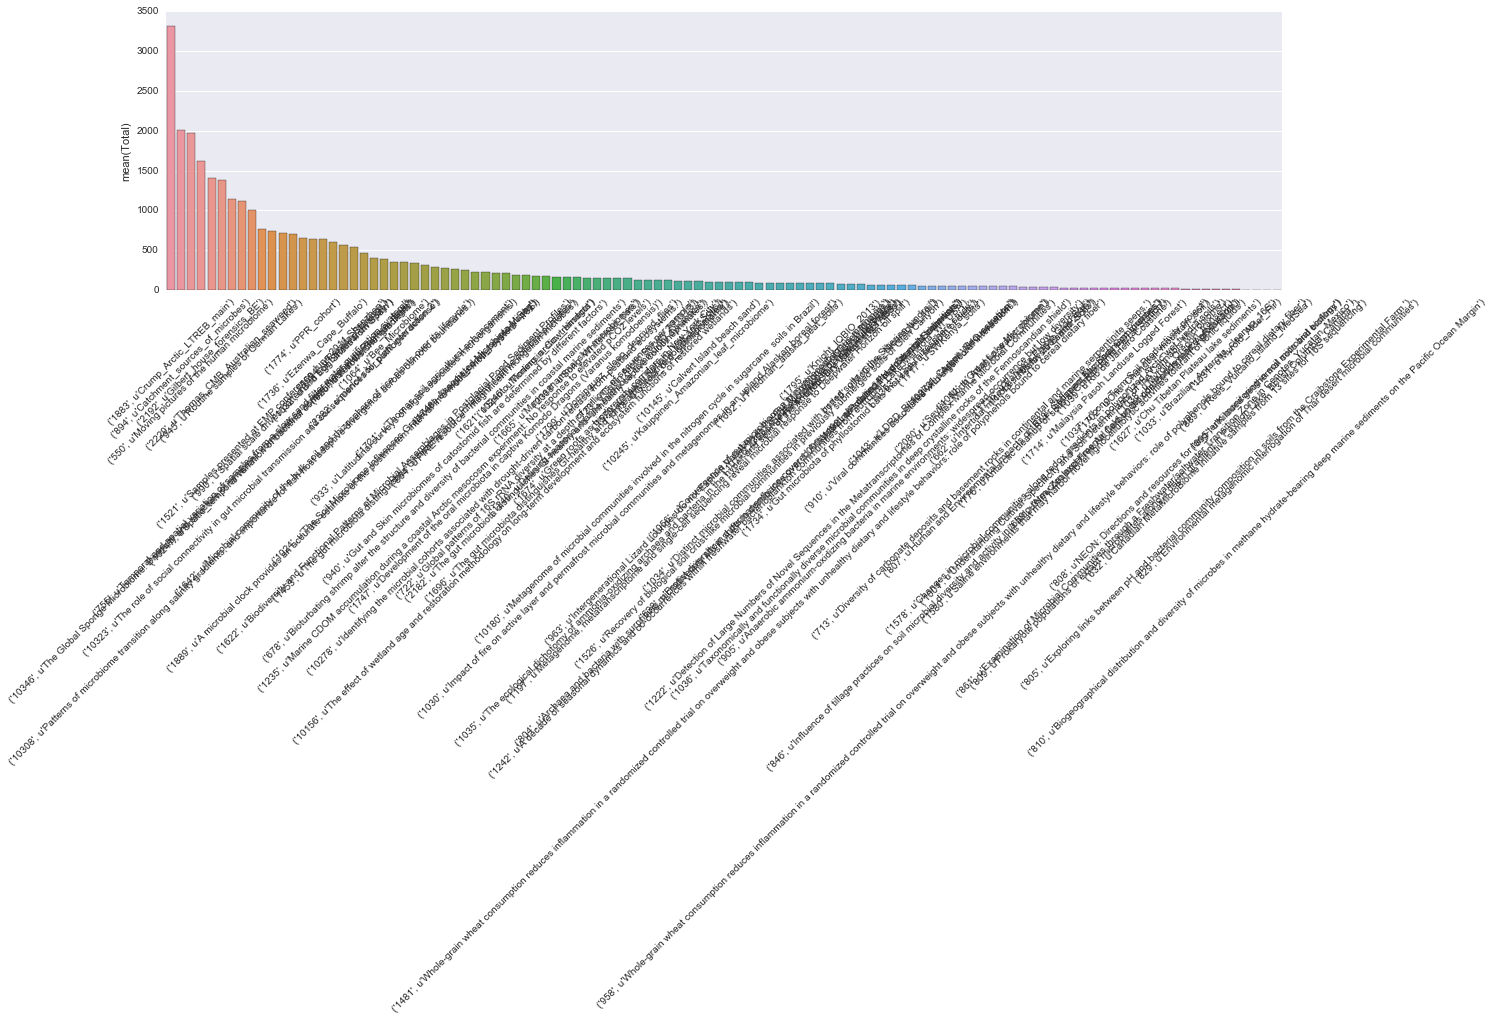

In [54]:
plt.figure(figsize=(20,5))
ph = sns.barplot(studies_groupby_unstack_sorted.index, studies_groupby_unstack_sorted)
for item in ph.get_xticklabels():
    item.set_rotation(45)

### Write merged refined mapping file

In [55]:
today = datetime.datetime.today()
df_refined.to_csv('/Users/luke/emp/metadata-refine/emp_qiime_mapping_refined_%s.tsv' % today.strftime('%Y%m%d'), sep='\t')

### Write list of studies

In [56]:
studies_groupby_unstack.to_csv('/Users/luke/emp/metadata-refine/emp_studies_no_controls_%s.tsv' % today.strftime('%Y%m%d'), sep='\t')

### Split and write individual refined mapping files

In [57]:
studies = [line.rstrip('\n') for line in open(path_studies)]
for study in studies:
    df_individual = df_refined[df_refined.study_id == study]
    df_individual.to_csv('/Users/luke/emp/metadata-refine/qiime-maps-refined/%s_qiime_mapping_refined.tsv' % study, sep='\t')